In [1]:
##detect speaker using Deep learning CNN

In [2]:
import os

#To check whether there is a file or not
from os.path import isfile,join

import shutil
import numpy as np

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio

#To control the processes 
import subprocess

import plotly.express as px

import librosa


In [3]:
data_directory = "16000_pcm_speeches"
audio_folder = "audio"
noise_folder = "noise"

audio_path = os. path.join(data_directory, audio_folder)
noise_path =os. path.join(data_directory, noise_folder)

In [4]:
audio_path

'16000_pcm_speeches\\audio'

In [5]:
noise_path

'16000_pcm_speeches\\noise'

In [6]:
voicefile_names=os.listdir("16000_pcm_speeches\\audio")

In [7]:
voicefile_names

['Benjamin_Netanyau',
 'Jens_Stoltenberg',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela']

In [8]:
noisefile_names=os.listdir("16000_pcm_speeches/noise")

In [9]:
noisefile_names

['other', '_background_noise_']

In [10]:
voice_files_count = []

In [11]:
for t in voicefile_names:
    p=os. listdir("16000_pcm_speeches/audio"+"/"+t)
    len_class=len(p)
    voice_files_count.append(len_class)

In [12]:
voice_files_count

[1500, 1500, 1501, 1500, 1500]

In [13]:
noise_files_count = []

In [14]:
for t in noisefile_names:
    p=os. listdir("16000_pcm_speeches/noise"+"/"+t)
    len_class=len(p)
    noise_files_count.append(len_class)

In [15]:
noise_files_count

[2, 4]

In [16]:
random_x = voicefile_names
random_y = voice_files_count

fig = px.bar(random_x, y = random_y)
fig.show()

In [17]:
random_x = noisefile_names
random_y = noise_files_count

fig = px.bar(random_x, y = random_y)
fig.show()

In [18]:
#Hyper parameters
valid_split = 0.1

shuffle_seed = 43

sample_rate = 16000

scale = 0.5

batch_size = 128

epochs = 15

In [19]:
noise_paths = []
for subdir in os.listdir(noise_path):
     subdir_path = Path(noise_path) / subdir
     if os.path.isdir(subdir_path):
         noise_paths += [
             os.path.join (subdir_path, filepath)
             for filepath in os.listdir(subdir_path)
             if filepath.endswith(".wav")
         ]


In [20]:
noise_paths

['16000_pcm_speeches\\noise\\other\\exercise_bike.wav',
 '16000_pcm_speeches\\noise\\other\\pink_noise.wav',
 '16000_pcm_speeches\\noise\\_background_noise_\\10convert.com_Audience-Claps_daSG5fwdA7o.wav',
 '16000_pcm_speeches\\noise\\_background_noise_\\doing_the_dishes.wav',
 '16000_pcm_speeches\\noise\\_background_noise_\\dude_miaowing.wav',
 '16000_pcm_speeches\\noise\\_background_noise_\\running_tap.wav']

In [21]:
x, sr = librosa.load('16000_pcm_speeches\\noise\\_background_noise_\\doing_the_dishes.wav')

In [22]:
print(x.shape)
print(sr)

(2098788,)
22050


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

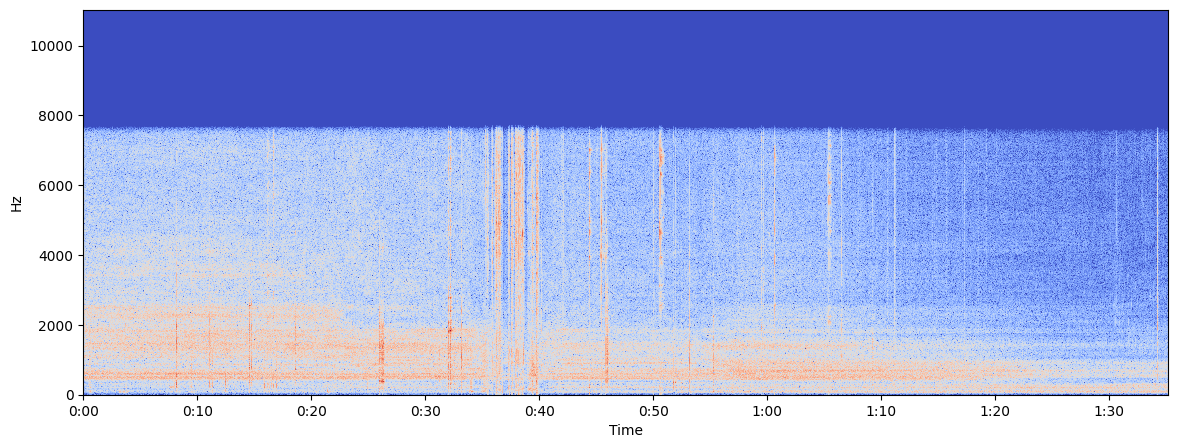

In [24]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz' )

In [25]:
import IPython.display as ipd
ipd.Audio('16000_pcm_speeches\\noise\\_background_noise_\\doing_the_dishes.wav') 

In [26]:
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    print(sampling_rate)
    
    if sampling_rate == sample_rate:
        print("sample",sample.shape[0])
        slices = int(sample.shape[0] / sample_rate)
        print(slices)
        sample = tf.split(sample[: slices * sample_rate], slices)
        
        return sample
    else:
        print("Sampling rate for",path, "is incorrect")
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

tf.Tensor(16000, shape=(), dtype=int32)
sample 980062
61
tf.Tensor(16000, shape=(), dtype=int32)
sample 960000
60
tf.Tensor(16000, shape=(), dtype=int32)
sample 260685
16
tf.Tensor(16000, shape=(), dtype=int32)
sample 1522930
95
tf.Tensor(16000, shape=(), dtype=int32)
sample 988891
61
tf.Tensor(16000, shape=(), dtype=int32)
sample 978488
61


In [27]:
noises

<tf.Tensor: shape=(354, 16000, 1), dtype=float32, numpy=
array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.00686646],
        [ 0.00787354],
        [ 0.03518677]],

       [[ 0.02255249],
        [ 0.02313232],
        [ 0.03659058],
        ...,
        [ 0.04666138],
        [ 0.01559448],
        [-0.00531006]],

       [[ 0.02670288],
        [ 0.00131226],
        [-0.02508545],
        ...,
        [ 0.02560425],
        [ 0.00949097],
        [ 0.02047729]],

       ...,

       [[-0.1736145 ],
        [-0.0144043 ],
        [ 0.01174927],
        ...,
        [-0.03097534],
        [-0.07894897],
        [-0.0625    ]],

       [[ 0.04071045],
        [ 0.01339722],
        [-0.050354  ],
        ...,
        [-0.11276245],
        [-0.0652771 ],
        [ 0.08911133]],

       [[-0.06359863],
        [ 0.034729  ],
        [ 0.01135254],
        ...,
        [ 0.00579834],
        [-0.07489014],
        [ 0.10739136]]], dtype=float3

In [28]:
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

In [29]:
def path_to_audio(path):
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, sample_rate)
    return audio

In [30]:
def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        audio = audio + noise * prop * scale

    return audio
     

In [31]:
def audio_to_fft(audio):
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

In [32]:
class_names = os.listdir(audio_path)
print(class_names,)

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Speaker:",(name))
    dir_path = Path(audio_path) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela']
Speaker: Benjamin_Netanyau
Speaker: Jens_Stoltenberg
Speaker: Julia_Gillard
Speaker: Magaret_Tarcher
Speaker: Nelson_Mandela


In [33]:
rng = np.random.RandomState(shuffle_seed)
rng.shuffle(audio_paths)
rng = np.random.RandomState(shuffle_seed)
rng.shuffle(labels)

In [34]:
num_val_samples = int(valid_split * len(audio_paths))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]


valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

In [35]:
inytrain_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=shuffle_seed).batch(32)

In [36]:
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=scale), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [37]:
from tensorflow.keras.layers import Conv1D

In [38]:
def residual_block(x, filters, conv_num = 3, activation = "relu"):
    s = keras.layers.Conv1D(filters, 1, padding = "same")(x)
    
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
        x = keras.layers.Activation(activation)(x)
    
    x = keras.layers.Conv1D(filters, 3, padding = "same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    
    return keras.layers.MaxPool1D(pool_size = 2, strides = 2)(x)

# def build_model(input_shape, num_classes):
#     inputs = keras.layers.Input(shape = input_shape, name = "input")
    
#     x = residual_block(inputs, 16, 2)
#     x = residual_block(inputs, 32, 2)
#     x = residual_block(inputs, 64, 3)
#     x = residual_block(inputs, 128, 3)
#     x = residual_block(inputs, 128, 3)
#     x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
#     x = keras.layers.Flatten()(x)
#     x = keras.layers.Dense(256, activation="relu")(x)
#     x = keras.layers.Dense(128, activation="relu")(x)
    
#     outputs = keras.layers.Dense(num_classes, activation = "softmax", name = "output")(x)
    
#     return keras.models.Model(inputs = inputs, outputs = outputs)

def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 128, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)

    # Add a Flatten layer to convert the 3D tensor to a 1D tensor
    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

model = build_model((sample_rate // 2, 1), len(class_names))

model.summary()

model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) 

model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy", save_best_only=True)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 8000, 128)            512       ['input[0][0]']               
                                                                                                  
 activation (Activation)     (None, 8000, 128)            0         ['conv1d_1[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 8000, 128)            49280     ['activation[0][0]']          
                                                                                            

In [39]:
epochs=1

In [40]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)



34/53 [==================>...........] - ETA: 7:06 - loss: 3.3512 - accuracy: 0.5368

In [ ]:
print("Accuracy of model:",model.evaluate(train_ds))

In [ ]:
print("Accuracy of model:",model.evaluate(valid_ds))

In [ ]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=scale), y))

for audios, labels in test_ds.take(1):
    ffts = audio_to_fft(audios)
    y_pred = model.predict(ffts)
    rnd = np.random.randint(0, batch_size, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        if labels[index] ==y_pred[index]:
            print("Welcome")
        else:
            print("Sorry")
        print("The speaker is" if labels[index] == y_pred[index] else "", class_names[y_pred[index]])

In [ ]:
def paths_to_dataset(audio_paths):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    return tf.data.Dataset.zip((path_ds))

def predict(path, labels):
    test = paths_and_labels_to_dataset(path, labels)


    test = test.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
    )
    test = test.prefetch(tf.data.experimental.AUTOTUNE)


    test = test.map(lambda x, y: (add_noise(x, noises, scale=scale), y))

    for audios, labels in test.take(1):
        ffts = audio_to_fft(audios)
        y_pred = model.predict(ffts)
        rnd = np.random.randint(0, 1, 1)
        audios = audios.numpy()[rnd, :]
        labels = labels.numpy()[rnd]
        y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(1):
            print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
            "[92m",y_pred[index],
                "[92m", y_pred[index]
                )
            )
            
            print("Speaker Predicted:",class_names[y_pred[index]])

In [ ]:
path = ["16000_pcm_speeches/audio/Nelson_Mandela/1035.wav"]
labels = ["unknown"]
try:
    predict(path, labels)
except:
    print("Error! Check if the file correctly passed or not!")

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Set the parent directory for speaker folders
parent_dir = "16000_pcm_speeches\\audio"

# List of speaker folders
speaker_folders = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela"
]

def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=None, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                
                # Normalize MFCC features
                mfccs = StandardScaler().fit_transform(mfccs)
                
                features.append(mfccs.T)
                labels.append(i)

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(parent_dir, speaker_folders)

In [ ]:
for feature in X[:1]:
    print(feature)

In [ ]:
model.summary()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ...

# After testing the model with the test dataset
test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(
    batch_size
)
test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=scale), y))

true_labels = []
predicted_labels = []

for audios, labels in test_ds:
    ffts = audio_to_fft(audios)
    y_pred = model.predict(ffts)
    predicted_labels.extend(np.argmax(y_pred, axis=-1))
    true_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(len(class_names), len(class_names)))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
